In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
from tqdm import tqdm # for progress bar
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer

# Libraries for TensorFlow
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from keras.models import Sequential
from keras import callbacks
# from livelossplot.inputs.keras import PlotLossesCallback
from keras.datasets import mnist, cifar10
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

# Library for Transfer Learning
from tensorflow.keras.applications import ResNet
from keras.applications.vgg16 import preprocess_input

In [2]:
(x_train,y_train), (x_test,y_test) = cifar10.load_data()

# making all the values range between 0 and 1
x_train = tf.pad(x_train, [[0, 0], [2, 2], [2, 2], [0, 0]], mode='constant') / 255
x_test = tf.pad(x_test, [[0, 0], [2, 2], [2, 2], [0, 0]], mode='constant') / 255

# Apply one-hot encoding to the image label : Ex: Class '1' = [0,1,0,0,0,0,0,0,0,0,0]
y_train = tf.keras.utils.to_categorical(y_train)
y_test  = tf.keras.utils.to_categorical(y_test)

## Training datasets : 48000 image samples - Validation datasets : 2000 image samples - Testing datasets : 10000 image samples
x_val = x_train[-2000:,:,:,:]
x_train = x_train[:-2000,:,:,:]
y_val = y_train[-2000:]
y_train = y_train[:-2000]


2023-05-08 17:58:24.811942: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 17:58:27.419486: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2642 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:c2:00.0, compute capability: 8.0


In [3]:
# Incorporating reduced learning and early stopping for callback
reduce_learning = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=2,
    min_lr=0)

eary_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = callbacks.ModelCheckpoint(filepath='model/resnet_cifar.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

callbacks_def = [reduce_learning, eary_stopping, tl_checkpoint_1]

In [4]:
# Using pooling='average' in ResNet50()  => ACCURACY: 0.11 - Not improving 
head_model = Sequential()
head_model.add(ResNet50(include_top=False, weights='imagenet', input_shape = (36,36,3)))
for layer in head_model.layers:
  layer.trainable = False

head_model.add(layers.GlobalAveragePooling2D())
head_model.add(layers.Dense(1024, activation='relu'))
head_model.add(layers.Dropout(0.1))
head_model.add(layers.Dense(512, activation='relu'))
head_model.add(layers.Dropout(0.1))
head_model.add(layers.Dense(10, activation='softmax'))
head_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

In [5]:
head_model.compile(optimizer='adam', loss=losses.categorical_crossentropy, metrics=['accuracy'])

history = head_model.fit(x_train, y_train, batch_size=64, epochs=40, validation_data=(x_val, y_val), callbacks=callbacks_def)


Epoch 1/40


2023-05-08 17:58:35.133837: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2023-05-08 17:58:36.698520: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-08 17:58:36.699543: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-08 17:58:36.699596: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-05-08 17:58:36.700952: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-08 17:58:36.701067: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


 11/750 [..............................] - ETA: 8s - loss: 2.5484 - accuracy: 0.1108   

2023-05-08 17:58:37.340429: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-05-08 17:58:37.340509: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-05-08 17:58:37.371426: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-05-08 17:58:37.371507: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

747/750 [============================>.] - ETA: 0s - loss: 2.0561 - accuracy: 0.2356
Epoch 1: val_loss improved from inf to 1.93216, saving model to model/resnet_cifar.weights.best.hdf5


2023-05-08 17:58:47.861736: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-05-08 17:58:47.861799: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-05-08 17:58:47.879113: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-05-08 17:58:47.879174: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

750/750 [==============================] - 18s 15ms/step - loss: 2.0552 - accuracy: 0.2362 - val_loss: 1.9322 - val_accuracy: 0.2925 - lr: 0.0010
Epoch 2/40
746/750 [============================>.] - ETA: 0s - loss: 1.9043 - accuracy: 0.3037
Epoch 2: val_loss improved from 1.93216 to 1.83571, saving model to model/resnet_cifar.weights.best.hdf5
750/750 [==============================] - 9s 12ms/step - loss: 1.9040 - accuracy: 0.3040 - val_loss: 1.8357 - val_accuracy: 0.3270 - lr: 0.0010
Epoch 3/40
746/750 [============================>.] - ETA: 0s - loss: 1.8391 - accuracy: 0.3311
Epoch 3: val_loss improved from 1.83571 to 1.79341, saving model to model/resnet_cifar.weights.best.hdf5
750/750 [==============================] - 9s 12ms/step - loss: 1.8392 - accuracy: 0.3312 - val_loss: 1.7934 - val_accuracy: 0.3515 - lr: 0.0010
Epoch 4/40
746/750 [============================>.] - ETA: 0s - loss: 1.7953 - accuracy: 0.3512
Epoch 4: val_loss improved from 1.79341 to 1.73337, saving model t

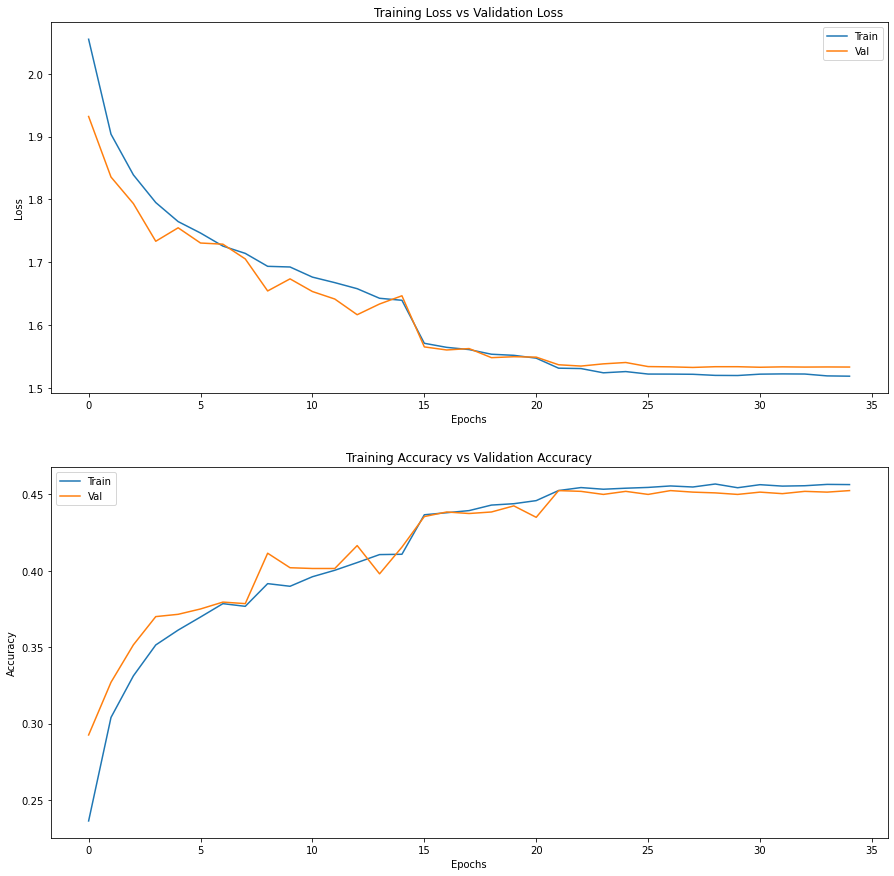

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [7]:
head_model.evaluate(x_test, y_test)

313/313 [==============================] - 4s 11ms/step - loss: 1.5253 - accuracy: 0.4553


[1.5252759456634521, 0.4553000032901764]

In [8]:
models.save_model(head_model, 'model/resnet_cifar')

2023-05-08 18:04:12.407116: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model/resnet_cifar/assets
